### Exploring Linear Regression

In [19]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Load Dataset (California Housing dataset from sklearn)

In [20]:
# Load dataset
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

### Create a Pandas DataFrame to Analyze the dataset

In [102]:
# Put the dataset along with the target variable in a pandas dataframe
data = pd.DataFrame(housing.data, columns=housing.feature_names)

# Add target column to data
data['target'] = housing['target']
data.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Check for missing values in the dataset

The dataset might have missing values represented by a `NaN`. Check if the dataset has such missing values.

In [103]:
# Check for missing values by presence of None, NaN, -inf values. 
boolNan = data.isnull().values.any()
boolInf = np.isinf(data)


print(f"The data has{'' if boolNan and boolInf else ' no'} missing values.")
assert not is_null(data)

The data has no missing values.


### EDA: Checking target distribution

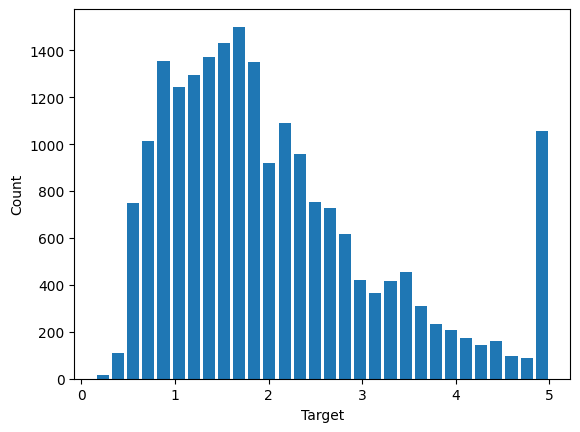

In [104]:
# Plot histogram of target variable
plt.xlabel("Target")
plt.ylabel("Count")
plt.hist(data['target'], bins = 30, rwidth = .8)
plt.show()

### Feature Exploration: Plotting the correlation matrix

<Axes: >

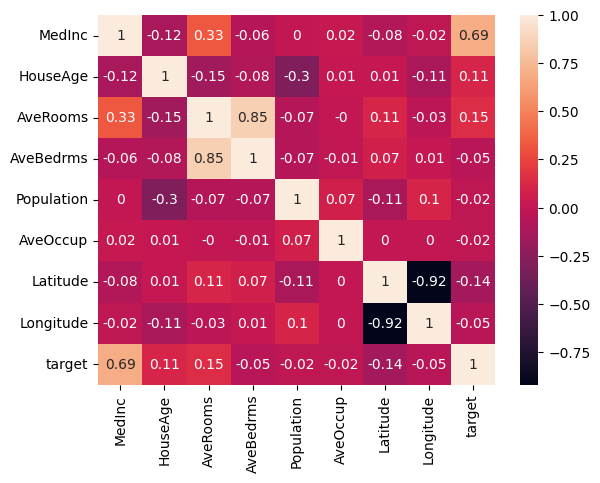

In [105]:
# Plot the correlation matrix
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

Let's check the correlations in a list view. We just want to see which features have the most direct linear relationship with the target feature, therefore absolute values are used. 

In [106]:
feature_abs = abs(correlation_matrix.iloc[:8, 8])
feature_abs.sort_values(ascending=False, inplace = True)
feature_abs

MedInc        0.69
AveRooms      0.15
Latitude      0.14
HouseAge      0.11
AveBedrms     0.05
Longitude     0.05
AveOccup      0.02
Population    0.02
Name: target, dtype: float64

We see from the absolute values that the features MedInc, AveRooms, Latitude and HouseAge have the highest correlation to our target. This includes both positive and negative influences. Intuitively we can see this makes sense. A higher number of rooms indicates more property, space, and possibly economic average of a neighborhood. Latitude for instance, determines the weather or climate of the location. It makes sense that. For simple exploration on this basic dataset, viewing the sorted correlations can give a quick view of what we are working with. 

## Data Manipulation: 
We want to format the data in a way that is conducive to the linear regression model. 
E.g. methods such as normalization

#### Normalize the dataset
We'll normalize the dataset ourselves to practice.
Normalizing the simple way, involves finding the mean and standard deviation of each feature. 
Using those values, for each entry of that feature, we subtract the mean, and divide by the standard distribution. 

In [107]:

features = np.concatenate([data[name].to_numpy()[:, None] for name in housing['feature_names']], axis=1)
target = housing['target']

def normalize(features, target):
    df_features = pd.DataFrame(features)
    df_target = pd.DataFrame(target)

    for col in df_features.columns:
        df_features[col] = (df_features[col] - df_features[col].mean()) / df_features[col].std()
        
    for col in df_target.columns:
        df_target[col] = (df_target[col] - df_target[col].mean()) / df_target[col].std()
        
    normFeat = df_features.to_numpy()
    normTarget = df_target.to_numpy()
    return normFeat, normTarget

features_normalized, target_normalized = normalize(features, target)

In [108]:
# === DO NOT MOVE/DELETE === Check that our means are near zero, and our standard deviations are near one. 
assert all(features_normalized.mean(axis=0) < 1e-2), "Mean should be close to 0"
assert all(features_normalized.std(axis=0) - 1 < 1e-2), "Standard deviation should be close to 1"
assert np.abs(target_normalized.mean(axis=0) < 1e-2), "Mean should be close to 0"
assert np.abs(target_normalized.std(axis=0) - 1 < 1e-2), "Standard deviation should be close to 1"

### Train-Test Split

We will use the conventional 80-20 split for the train-test split of this dataset. 
The linear regression model will be trained on the 80 portion, while tested on the smaller portion. 
SKLearn has an easy train_test_split(features, target, test_size) function.

In [109]:
# split the data 
X_train, X_test, Y_train, Y_test = train_test_split(features_normalized, target_normalized, test_size = 0.2, random_state=(1))

In [110]:
# sanity test the shapes of our splits
assert(X_train.shape[1] == 8), 'X_train has the incorrect number of features'
assert(X_test.shape[1] == 8), 'X_test has the incorrect number of features'
assert(Y_train.shape[1] == 1) , 'Y_train should only have the target column'
assert(Y_test.shape[1] == 1), 'Y_test should only have the target column'

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(16512, 8)
(4128, 8)
(16512, 1)
(4128, 1)


## Part 3: Linear Regression

In this part, a linear regression model will be used to fit the dataset loaded and normalized above.

We'll implement closed-form OLS regression with the prediction output as RMSE and $R^2$ 

The closed-form OLS equation is 'theta'=$(X^T * X)^{-1} * X^T * Y$

In [111]:
class MyLinearRegression:
    def __init__(self):
        # type: ndarray
        self.theta = None
    
    def fit(self, X, Y):
        # Given X and Y, compute theta using the closed-form solution for linear regression.
        # theta is now a ndarray
        copyX = np.array(X)
        copyY = np.array(Y)
        term1 = np.linalg.inv(np.transpose(copyX).dot(copyX))
        term2 = np.transpose(copyX).dot(copyY)
        self.theta = term1.dot(term2)
    
    def predict(self, X):
        # Predict Y for a given X
        res = X.dot(self.theta)
        return res

In [112]:
# Train the model on (X_train, Y_train) using Linear Regression 
my_model = MyLinearRegression()
my_model.fit(X_train, Y_train)

In [120]:
from sklearn.metrics import mean_squared_error, r2_score

y_train_predict = my_model.predict(X_train)
train_rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
train_r2 = r2_score(Y_train, y_train_predict)

y_test_predict = my_model.predict(X_test)
test_rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
test_r2 = r2_score(Y_test, y_test_predict)


print("\n")
print("Performance for Personal Linear Regression on All Normalized Data: ")
print("--------------------------------------")
print('Train RMSE is {}'.format(train_rmse))
print('Train R2 score is {}'.format(train_r2))
print('Test RMSE is {}'.format(test_rmse))
print('Test R2 score is {}'.format(test_r2))
print("\n")




Performance for Personal Linear Regression on All Normalized Data: 
--------------------------------------
Train RMSE is 0.6782393368028877
Train R2 score is 0.5415454375862339
Test RMSE is 0.6757163469657428
Test R2 score is 0.5364719898751233




#### Compare with the LinearRegression from sklearn.linear_model
To ensure we implemented OLS linear regression correctly, let's compare our model to the one from SKLearn

In [122]:
model = LinearRegression().fit(X_train, Y_train)

# model evaluation for training set
y_train_predict = model.predict(X_train)
sklearn_train_rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
sklearn_train_r2 = r2_score(Y_train, y_train_predict)

# model evaluation for testing set
y_test_predict = model.predict(X_test)
sklearn_test_rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
sklearn_test_r2 = r2_score(Y_test, y_test_predict)

print("Performance for sklearn Linear Regression on All Normalized Data: ")
print("--------------------------------------")
print('Train RMSE is {}'.format(sklearn_train_rmse))
print('Train R2 score is {}'.format(sklearn_train_r2))
print('Test RMSE is {}'.format(sklearn_test_rmse))
print('Test R2 score is {}'.format(sklearn_test_r2))
print("\n")

Performance for sklearn Linear Regression on All Normalized Data: 
--------------------------------------
Train RMSE is 0.678218448836547
Train R2 score is 0.5415736755119581
Test RMSE is 0.6759049950618269
Test R2 score is 0.5362131360428868




We can see that our model is extremely similar in performance to the SKLearn provided model. 

#### For fun, let's check the difference between normalized and unnormalized data performance. 



In [123]:
# All Unnormalized data vs all normalized data
X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:,:8], data.iloc[:,8], test_size = 0.2, random_state=(1))
my_model = MyLinearRegression()
my_model.fit(X_train, Y_train)

y_test_predict = my_model.predict(X_test)
test_rmse_unnormal= (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
test_r2_unnormal = r2_score(Y_test, y_test_predict)

print("Performance of All Un-Normalized Data: ")
print("--------------------------------------")
print('Test RMSE is {}'.format(test_rmse_unnormal))
print('Test R2 score is {}'.format(test_r2_unnormal))
print('The absolute difference of RMSE: {}'.format(abs(test_rmse - test_rmse_unnormal)))
print('The absolute difference of R2: {}'.format(abs(test_r2 - test_r2_unnormal)))
print("\n")

Performance of All Un-Normalized Data: 
--------------------------------------
Test RMSE is 0.7751329760975735
Test R2 score is 0.5419415073430147
The absolute difference of RMSE: 0.09941662913183069
The absolute difference of R2: 0.005469517467891372




We can easily see that the performance degrades if we don't normalize the features and target. A lower RMSE indicates a better fit and less overall residuals from the actual data points. Meanwhile, the $R^2$ is the coefficient of determination. It is the proportion of the variance of the target variable that can be explained by the features.

### Check what happens when we train on all features versus only the top 5 relevant features. Both are normalized. 



In [124]:
top5 =  mostRel(correlation_matrix) # #medinc (0), averooms(2), lat(6), house age(1), avebedrms (3)
df_normFeat = pd.DataFrame(features_normalized)
X_train, X_test, Y_train, Y_test = train_test_split(df_normFeat.iloc[:,[0,1,2,3,6]], target_normalized, test_size = 0.2, random_state=(1))
my_model = MyLinearRegression()
my_model.fit(X_train, Y_train)

y_test_predict = my_model.predict(X_test)
test_rmse_top5 = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
test_r2_top5 = r2_score(Y_test, y_test_predict)

print("Performance of Top 5 Normalized Features: ")
print("--------------------------------------")
print('Test RMSE is {}'.format(test_rmse_top5))
print('Test R2 score is {}'.format(test_r2_top5))
print('The absolute difference of RMSE: {}'.format(abs(test_rmse - test_rmse_top5)))
print('The absolute difference of R2: {}'.format(abs(test_r2 - test_r2_top5)))
print("\n")

Performance of Top 5 Normalized Features: 
--------------------------------------
Test RMSE is 0.6757163469657428
Test R2 score is 0.5364719898751233
The absolute difference of RMSE: 0.0
The absolute difference of R2: 0.0




We see here that there is little difference in performance when predicting on the test set. Often times, we only need a few powerful features that account for most of the variance. Feature selection also allows generalization of the model when in production. 